# **Import**

In [1]:
!pip install xlsxwriter
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 34.9 MB/s eta 0:00:00


In [2]:
import sys
from typing import Callable, Union
from google.colab import files
import xlsxwriter
from pylab import rcParams
import pandas as pd
import numpy as np
from pulp import LpMaximize, LpProblem, lpDot, LpVariable
import seaborn as sns

In [3]:
EPS = sys.float_info.epsilon

# **Functions**

In [4]:
def init_ranking(df: pd.DataFrame) -> pd.DataFrame:
    """Создает таблицу ранжирований (без пропусков) на основе таблицы рейтингов"""
    rankings = list(df.columns)
    for ranking in rankings:
        res = np.zeros(len(df))
        place = 1
        maximum = df[ranking].max()
        while maximum != -100:
            ind_list = np.where(df[ranking] == maximum)
            for ind in ind_list:
                df[ranking][ind] = -100
                res[ind] = place
            place += 1
            maximum = df[ranking].max()
        df[ranking] = res
    df = df.astype("int")
    return df

In [5]:
def M_T_generator(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Создает матрицу строго строгого мажоритарного отношения M и матрицу отношения равенства голосов T на основе матрицы ранжирований"""
    values = df.values
    M = np.zeros((values.shape[0], values.shape[0]))
    T = np.zeros((values.shape[0], values.shape[0]))
    num = 0
    for i in range(values.shape[0]):
        for j in range(values.shape[0]):
            counter = 0
            for k in range(1, values.shape[1]):
                if values[i][k] < values[j][k]:
                    counter += 1
                elif values[i][k] > values[j][k]:
                    counter -= 1
            if np.sign(counter) == 1:
                M[i][j] = 1
            elif np.sign(counter) == 0 and i != j:
                T[i][j] = 1
                num += 1
    return M.astype(np.int64), T.astype(np.int64)

In [6]:
def game_creator(M: np.ndarray) -> np.ndarray:
    """Создает матрицу турнирной игры G на основе матрица строгого мажоритарного отношения M"""
    return M - M.T

In [7]:
def G_reduction(G: np.ndarray, el_to_del: int) -> np.ndarray:
    """Удаляет из матрицы G строку и столбец с индексом el_to_del"""
    G = np.delete(G, el_to_del, 0)
    return np.delete(G, el_to_del, 1)

Верхний срез альтернативы $x$:

$$D(x) = \{y \in X ~|~ yPx\}$$

Нижний срез альтернативы $x$:

$$L(x) = \{y \in X ~|~ xPy\}$$

Горизонт альтернативы $x$:

$$H(x) = \{y \in X \setminus \{x\} ~|~ \lnot xPy \land \lnot yPx\}$$


In [8]:
def DLH(G: np.ndarray) -> dict[str, list[set[int]]]:
    """Вычисляет верхний и нижний срезы и горизонт каждой альтернативы"""
    D = []
    L = []
    H = []
    for i in range(len(G)):
        D.append(set(j for j in range(len(G)) if G[i][j] == -1))
        L.append(set(j for j in range(len(G)) if G[i][j] == 1))
        H.append(set(j for j in range(len(G)) if G[i][j] == 0 and i != j))
    return {"D": D, "L": L, "H": H}

Оценка Коупланда (2 версия) альтернативы $x$:

$$s2(x) = |L(x)|$$

In [9]:
def CO_2(G: np.ndarray) -> list[int]:
    """Вычисляет оценки Коупланда (2 версия) для всех альтернатив предъявления"""
    L = DLH(G)['L']
    s2_list = list(map(len, L))
    return s2_list

Оценка Коупланда (3 версия) альтернативы $x$:

$$s3(x) = |X| - |D(x)|$$

In [10]:
def CO_3(G: np.ndarray) -> list[int]:
    """Вычисляет оценки Коупланда (3 версия) для всех альтернатив предъявления"""
    card_X = len(G)
    D = DLH(G)['D']
    s3_list = [card_X - len(D_x) for D_x in D]
    return s3_list

Версия Миллера отношения покрытия: 

$$x C_M y \Leftrightarrow xPy \land L(y) \subset L(x)$$

Альтернатива называется непокрытой по Миллеру тогда и только тогда, когда в предъявлении нет ни одной альтернативы, её покрывающей по Миллеру. 

Непокрытое по Миллеру множество $UC_M$ есть множество всех непокрытых по версии Миллера отношения покрытия альтернатив 

$$UC_M=\{x \in X~|~\forall y \in X,\lnot yC_Mx\}$$

In [11]:
def UC_M(G: np.ndarray) -> set[int]:
    """Вычисляет непокрытое по Миллеру множество UC_M"""
    all_alt_set = set(i for i in range(len(G)))
    L = DLH(G)["L"]
    covered = set()
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and (L[j] < L[i]):
                covered.add(j)
    return all_alt_set - covered

Версия Фишберна отношения покрытия: 

$$x C_F y \Leftrightarrow xPy \land D(x) \subset D(y)$$

Альтернатива называется непокрытой по Фишберну тогда и только тогда, когда в предъявлении нет ни одной альтернативы, её покрывающей по Фишберну. 

Непокрытое по Фишберну множество $UC_F$ есть множество всех непокрытых по версии Фишберна отношения покрытия альтернатив 

$$UC_F=\{x \in X~|~\forall y \in X,\lnot yC_Fx\}$$

In [12]:
def UC_F(G: np.ndarray) -> set[int]:
    """Вычисляет непокрытое по Фишберну множество UC_F"""
    all_alt_set = set(i for i in range(len(G)))
    D = DLH(G)["D"]
    covered = set()
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and (D[i] < D[j]):
                covered.add(j)
    return all_alt_set - covered

Версия МакКельви отношения покрытия:

$$x C_{McK} y \Leftrightarrow xPy \land \big(D(x) \subset D(y)\big) \land \big(L(y) \subset L(x)\big)$$

Альтернатива называется непокрытой по МакКельви тогда и только тогда, когда в предъявлении нет ни одной альтернативы, её покрывающей по МакКельви. 

Непокрытое по МакКельви множество $UC_{McK}$ есть множество всех непокрытых по версии МакКельви отношения покрытия альтернатив 

$$UC_{McK}=\{x \in X~|~\forall y \in X,\lnot yC_{McK}x\}$$

In [13]:
def UC_McK(G: np.ndarray) -> set[int]:
    """Вычисляет непокрытое по МакКельви множество UC_McK"""
    all_alt_set = set(i for i in range(len(G)))
    L = DLH(G)["L"]
    D = DLH(G)["D"]
    covered = set()
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and (D[i] < D[j]) and (L[j] < L[i]):
                covered.add(j)
    return all_alt_set - covered

Версия Дуггана отношения покрытия:

$$x C_{D} y \Leftrightarrow \big(H(y) \cup L(y)\big) \subset L(x)$$

Альтернатива называется непокрытой по Дуггану тогда и только тогда, когда в предъявлении нет ни одной альтернативы, её покрывающей по Дуггану. 

Непокрытое по Дуггану множество $UC_D$ есть множество всех непокрытых по версии Дуггану отношения покрытия альтернатив 

$$UC_D=\{x \in X~|~\forall y \in X,\lnot yC_Dx\}$$

In [14]:
def UC_D(G: np.ndarray) -> set[int]:
    """Вычисляет непокрытое по Дуггану множество UC_D"""
    all_alt_set = set(i for i in range(len(G)))
    L = DLH(G)["L"]
    H = DLH(G)["H"]
    covered = set()
    for i in range(len(G)):
        for j in range(len(G)):
            if H[j].union(L[j]) < L[i]:
                covered.add(j)
    return all_alt_set - covered

Объединение минимальных внешне устойчивых множеств $ES$:

$$x \in ES \Leftrightarrow \exists y \in UC_F: xPy \lor x \in UC_F$$

Алгоритм вычисления взят из статьи:

Subochev, A. Dominating, weakly stable, and uncovered sets: Properties and generalizations. / A. Subochev // Automation and Remote Control. – 2010. – Vol. 71(1). – p. 116-127.

In [15]:
def ES(G: np.ndarray) -> set[int]:
    """Вычисляет объединение минимальных внешне устойчивых множеств ES"""
    res = set()
    D = DLH(G)["D"]
    UC_F_set = UC_F(G)
    for y in UC_F_set:
        res = res.union(D[y])
    return res.union(UC_F_set)

Существенное множество $E$ определяется как объединение носителей всех максимальных лотерей слабого турнира.

Алгоритм вычисления взят из статьи:

Brandt, F. Computing the minimal covering set. / F. Brandt, F. Fischer // Mathematical Social Sciences. – 2008. – Vol. 56(2). – p. 254–268.

In [16]:
def E(G: np.ndarray) -> set[int]:
    """Вычисляет существенное множество E"""
    list_ind = [i for i in range(len(G))]
    # Вектор коэффициентов целевой функции
    z = [1, *[0 for _ in range(len(G))], -1000, *[0] * (len(G[0]) * 2)]
    # Матрица коэффициентов левой части
    A = []
    A_0 = [0, *[1 for _ in range(len(G))], 1, *[0 for _ in range(len(G) * 2)]]
    A.append(A_0)
    i = 0
    for row in np.vstack((G, G)):
        to_add = [0] * (len(G[0]) * 2 + 1)
        to_add[i + 1] = 1
        if i <= len(G) - 1:
            A_i = [0, *row, *to_add]
        else:
            row[i - len(G)] -= 1
            A_i = [1, *row, *to_add]
        A.append(A_i)
        i += 1
    # Вектор коэффициентов правой части
    b = [1, *[0 for _ in range(len(A) - 1)]]
    # Построение модели
    E = LpProblem(name="E", sense=LpMaximize)
    # Переменные задачи
    all_ind = list(map(str, list_ind)) + [str(list_ind[-1] + 1)]
    for i in range(len(A[0]) - len(list_ind) - 1):
        all_ind.append("*" * (i + 1))
    p = [LpVariable(name='p' + i, lowBound=0) for i in all_ind]
    # Ограничения
    for k in [i for i in range(len(G[0]) * 2 + 1)]:
        E += (lpDot(A[k], p) == b[k]), '(' + str(k + 1) + ')'
    # Целевая функция
    E += lpDot(z, p)
    # Решение задачи
    E.solve()
    res = set()
    for v in E.variables():
        if v.varValue > EPS and "*" not in v.name and v.name != 'p0':
            res.add(int(v.name.replace('p', '')) - 1)
    return res

В слабом турнире покрывающим по МакКельви множеством $Y \subseteq X$ называют множество, удовлетворяющее следующим двум условиям:

1. $UC_{McK}(Y) = Y$
2. $\forall x \in X \setminus Y, x \notin UC_{McK}(Y\cup\{x\})$

Минимальное покрывающее по МакКельви множество определяется как единственное минимальное по вложению покрывающее по МакКельви множество.

Алгоритм вычисления взят из статьи:

Brandt, F. Computing the minimal covering set. / F. Brandt, F. Fischer // Mathematical Social Sciences. – 2008. – Vol. 56(2). – p. 254–268.

In [17]:
def MC_McK(G: np.ndarray) -> set[int]:
    """Вычисляет минимальное покрывающее по МакКельви множество MC_McK"""
    B = E(G)
    all_alt = set([x for x in range(len(G))])
    while True:
        temp_res = set()
        for el in all_alt - B:
            el_to_del = list(all_alt - B.union({el}))
            UC_McK_set = UC_McK(G_reduction(G, el_to_del))
            el_to_stay = list(B.union({el}))
            el_to_stay.sort()
            UC_new = set()
            for ind in UC_McK_set:
                UC_new.add(el_to_stay[ind])
            if UC_new.intersection({el}) != set():
                temp_res.add(el)
        if len(temp_res) == 0:
            return B
        else:
            el_to_del = list(all_alt - temp_res)
            el_to_stay = list(temp_res)
            el_to_stay.sort()
            A_new = E(G_reduction(G, el_to_del))
            to_add = set()
            for ind in A_new:
                to_add.add(el_to_stay[ind])
            B = B.union(to_add)

В слабом турнире покрывающим по Дуггану множеством $Y \subseteq X$ называют множество, удовлетворяющее следующим двум условиям:

1. $UC_D(Y) = Y$
2. $\forall x \in X \setminus Y, x \notin UC_D(Y\cup\{x\})$

Минимальное покрывающее по Дуггану множество определяется как единственное минимальное по вложению покрывающее по Дуггану множество.

$MC_D$ вычисляется аналогично $MC_{McK}$.

In [18]:
def MC_D(G: np.ndarray) -> set[int]:
    """Вычисляет минимальное покрывающее по Дуггану множество MC_McK"""
    B = E(G)
    all_alt = set([x for x in range(len(G))])
    while True:
        temp_res = set()
        for el in all_alt - B:
            el_to_del = list(all_alt - B.union({el}))
            UC_D_set = UC_D(G_reduction(G, el_to_del))
            el_to_stay = list(B.union({el}))
            el_to_stay.sort()
            UC_new = set()
            for ind in UC_D_set:
                UC_new.add(el_to_stay[ind])
            if UC_new.intersection({el}) != set():
                temp_res.add(el)
        if len(temp_res) == 0:
            return B
        else:
            el_to_del = list(all_alt - temp_res)
            el_to_stay = list(temp_res)
            el_to_stay.sort()
            A_new = E(G_reduction(G, el_to_del))
            to_add = set()
            for ind in A_new:
                to_add.add(el_to_stay[ind])
            B = B.union(to_add)

In [19]:
def sorting(G: np.ndarray, func: Callable[[np.ndarray], Union[set[int], list[int]]]) -> list[int]:
    """Производит сортировку альтернатив из предъявления по правилу, заданному функцией func"""
    rank_all = []
    N = len(G)
    if func in [CO_2, CO_3]:
        index_all = [x for x in range(len(G))]
        score = func(G)
        dict_temp = dict(zip(index_all, score))
        keys_sorted = sorted(dict_temp, key=dict_temp.get, reverse=True)
        value_max = dict_temp[keys_sorted[0]]
        rank_temp = []
        while value_max != -1:
            for key in keys_sorted:
                value_now = dict_temp[key]
                if value_now == value_max:
                    dict_temp[key] = -1
                    rank_temp.append(key)
            rank_all.append(rank_temp)
            rank_temp = []
            keys_sorted = sorted(dict_temp, key=dict_temp.get, reverse=True)
            value_max = dict_temp[keys_sorted[0]]
    else:
        index_left = [x for x in range(len(G))]
        while True:
            if len(G) == 0:
                break
            rank_temp = []
            res_temp = func(G)
            for el_ind in res_temp:
                rank_temp.append(index_left[el_ind])
            index_left = [index_left[i] for i in range(len(index_left)) if i not in res_temp]
            G = G_reduction(G, list(res_temp))
            rank_all.append(rank_temp)
    place = 1
    ranking = [0] * N
    for place_list in rank_all:
        for i in place_list:
            ranking[i] = place
        place += 1
    return ranking

# **Main**

In [20]:
uploaded = files.upload()
for file in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

Saving initial_data.csv to initial_data.csv
User uploaded file "initial_data.csv" with length 11765 bytes


In [21]:
df = pd.read_csv(file, delimiter=";")
df = df.set_index(df.columns[0])
df

,2YIF,5YIF,AI,SNIP,SJR
Title,,,,,
annual review of organizational psychology and organizational behavior,18.333,20.485,8.071,8.886,9.807
academy of management annals,16.438,23.832,11.791,9.324,18.318
international journal of management reviews,13.419,15.493,4.039,5.548,4.475
academy of management review,12.638,18.362,8.486,4.281,8.446
journal of management,11.790,16.662,5.874,5.756,7.491
...,...,...,...,...,...
review of industrial organization,1.054,1.069,0.512,0.977,0.385
international journal of arts management,1.000,1.032,0.230,0.621,0.348
south african journal of economic and management sciences,0.991,1.054,0.197,0.736,0.277


In [22]:
rankings_all = init_ranking(df)
rankings_all

,2YIF,5YIF,AI,SNIP,SJR
Title,,,,,
annual review of organizational psychology and organizational behavior,1,2,3,2,4
academy of management annals,2,1,1,1,1
international journal of management reviews,3,6,11,4,14
academy of management review,4,3,2,7,5
journal of management,5,4,5,3,6
...,...,...,...,...,...
review of industrial organization,169,173,140,152,162
international journal of arts management,170,175,168,172,165
south african journal of economic and management sciences,171,174,170,170,169


In [23]:
M, T = M_T_generator(rankings_all)
G = game_creator(M)

In [24]:
tournament_solutions = [CO_2, CO_3, UC_M, ES, E, MC_McK, MC_D]
sol_names = ["Copeland rule (2 v.)", "Copeland rule (3 v.)", "sorting by UC", "sorting by ES", "sorting by E",
             "sorting by MC_McK", "sorting by MC_D"]
for i in range(len(tournament_solutions)):
    ranking = sorting(G, tournament_solutions[i])
    rankings_all[sol_names[i]] = ranking
rankings_all

,2YIF,5YIF,AI,SNIP,SJR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D
Title,,,,,,,,,,,,
annual review of organizational psychology and organizational behavior,1,2,3,2,4,2,2,2,2,2,2,2
academy of management annals,2,1,1,1,1,1,1,1,1,1,1,1
international journal of management reviews,3,6,11,4,14,7,5,5,5,5,5,5
academy of management review,4,3,2,7,5,3,3,3,3,3,3,3
journal of management,5,4,5,3,6,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
review of industrial organization,169,173,140,152,162,106,105,30,35,56,37,14
international journal of arts management,170,175,168,172,165,111,110,34,37,59,40,16
south african journal of economic and management sciences,171,174,170,170,169,111,112,36,39,61,42,16


In [25]:
corr = rankings_all.corr(method='kendall')
ind = corr.columns
corr

,2YIF,5YIF,AI,SNIP,SJR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D
2YIF,1.000000,0.799371,0.606557,0.714827,0.660544,0.739677,0.727825,0.718198,0.723020,0.722775,0.720302,0.755628
5YIF,0.799371,1.000000,0.719193,0.738194,0.727460,0.838808,0.832741,0.831328,0.836056,0.830427,0.835100,0.851452
AI,0.606557,0.719193,1.000000,0.654937,0.796660,0.822047,0.837998,0.862924,0.852678,0.846690,0.855829,0.840142
SNIP,0.714827,0.738194,0.654937,1.000000,0.712648,0.803621,0.787643,0.784780,0.787327,0.783473,0.784196,0.808797
SJR,0.660544,0.727460,0.796660,0.712648,1.000000,0.864596,0.871530,0.883297,0.878844,0.876863,0.881581,0.858958
Copeland rule (2 v.),0.739677,0.838808,0.822047,0.803621,0.864596,1.000000,0.940334,0.945584,0.941396,0.933759,0.943739,0.911148
Copeland rule (3 v.),0.727825,0.832741,0.837998,0.787643,0.871530,0.940334,1.000000,0.962846,0.962505,0.971373,0.969341,0.937769
sorting by UC,0.718198,0.831328,0.862924,0.784780,0.883297,0.945584,0.962846,1.000000,0.971216,0.965281,0.982341,0.931574
sorting by ES,0.723020,0.836056,0.852678,0.787327,0.878844,0.941396,0.962505,0.971216,1.000000,0.964020,0.979807,0.931492
sorting by E,0.722775,0.830427,0.846690,0.783473,0.876863,0.933759,0.971373,0.965281,0.964020,1.000000,0.975734,0.931982


<Axes: >

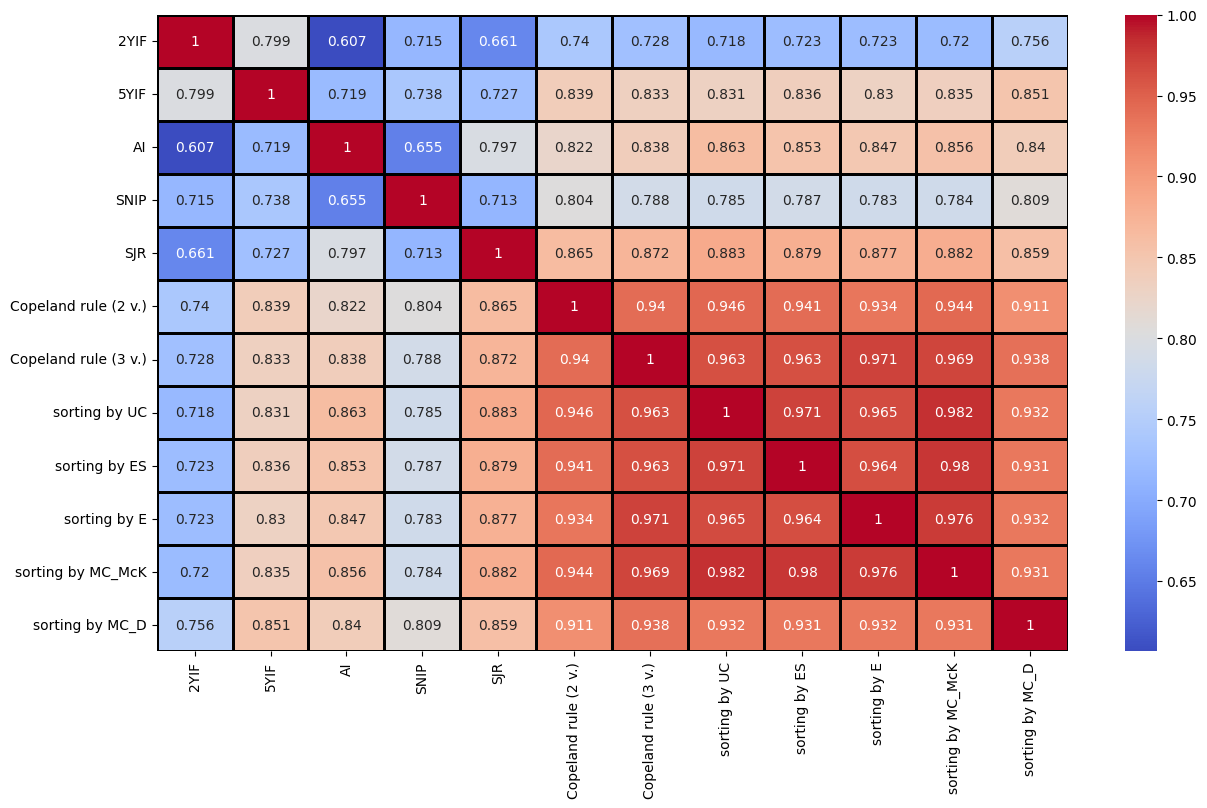

In [26]:
rcParams['figure.figsize'] = 14.7,8.27
sns.heatmap(corr,
            xticklabels=ind,
            yticklabels=ind,
            cmap='coolwarm',
            annot=True,
            fmt='.3g',
            linecolor='black',
            linewidth=1
            )

In [27]:
matrix = [[0 for _ in range(len(ind))] for _ in range(len(ind))]
for i in range(len(ind)):
    for j in range(len(ind)):
        val_i = 0
        val_j = 0
        if i < j:
            for k in range(len(df.columns)):
                if corr.iloc[k, i] - corr.iloc[k, j] > EPS:
                    val_i += 1
                elif corr.iloc[k, i] - corr.iloc[k, j] < - EPS:
                    val_j += 1
            if val_i > val_j:
                matrix[i][j] = 1
            elif val_i < val_j:
                matrix[j][i] = 1
matrix_pd = pd.DataFrame(matrix, index=ind, columns=ind)
res = pd.DataFrame(matrix, columns=ind, index=ind)
sum_col = []
for row in matrix:
    sum_row = sum(row)
    sum_col.append(sum_row)
res["Copeland score s2"] = sum_col
res

,2YIF,5YIF,AI,SNIP,SJR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D,Copeland score s2
2YIF,0,0,1,0,1,0,0,0,0,0,0,0,2
5YIF,1,0,1,1,1,0,0,0,0,0,0,0,4
AI,0,0,0,0,0,0,0,0,0,0,0,0,0
SNIP,1,0,1,0,1,0,0,0,0,0,0,0,3
SJR,0,0,1,0,0,0,0,0,0,0,0,0,1
Copeland rule (2 v.),1,1,1,1,1,0,1,1,1,1,1,0,10
Copeland rule (3 v.),1,1,1,1,1,0,0,1,0,1,0,0,7
sorting by UC,1,1,1,1,1,0,0,0,0,1,1,0,7
sorting by ES,1,1,1,1,1,0,1,1,0,1,1,0,9
sorting by E,1,1,1,1,1,0,0,0,0,0,0,0,5


In [28]:
pos = [x + 1 for x in range(len(ind))]
res_sorted = res.sort_values(by="Copeland score s2", ascending=False)
ind_ranked = res_sorted.index
final_ranking = pd.DataFrame(ind_ranked, columns=["Метод"], index=pos)
rank = []
counter = 1
value_prev = res_sorted["Copeland score s2"].values.max()
for value in res_sorted["Copeland score s2"]:
    if value < value_prev:
        counter += 1
    rank.append(counter)
    value_prev = value
final_ranking["Ранг"] = rank
final_ranking = final_ranking.set_index("Ранг")
final_ranking

,Метод
Ранг,
1,sorting by MC_D
2,Copeland rule (2 v.)
3,sorting by ES
4,Copeland rule (3 v.)
4,sorting by UC
4,sorting by MC_McK
5,sorting by E
6,5YIF
7,SNIP


In [29]:
with pd.ExcelWriter("Results.xlsx", engine='xlsxwriter') as writer:
    rankings_all.to_excel(writer, sheet_name="Rankings")
    pd.DataFrame(M).to_excel(writer, sheet_name="M", header=None, index=None)
    pd.DataFrame(T).to_excel(writer, sheet_name="T", header=None, index=None)
    corr.to_excel(writer, sheet_name="tau_b")
    res.to_excel(writer, sheet_name="M (tau_b)")
    final_ranking.to_excel(writer, sheet_name="Ranking of rankings (tau_b)")
files.download("Results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>